In [1]:
import torch
import torchaudio
import torchaudio.functional as F

In [2]:
data_root_path = 'audio_study/data/study_data'

In [3]:
import math
import os

import matplotlib.pyplot as plt
import requests
from IPython.display import Audio, display


_SAMPLE_DIR = "_assets"

SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(data_root_path, "steam.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"  # noqa: E501
SAMPLE_RIR_PATH = os.path.join(data_root_path, "rir.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(data_root_path, "speech.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"  # noqa: E501
SAMPLE_NOISE_PATH = os.path.join(data_root_path, "bg.wav")

os.makedirs(data_root_path, exist_ok=True)


def _fetch_data():
    uri = [
        (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
        (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
        (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    ]
    for url, path in uri:
        with open(path, "wb") as file_:
            file_.write(requests.get(url).content)


_fetch_data()


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    # frames / sample_rate 就是播放时间长度

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        return Audio(waveform[0], rate=sample_rate)
    elif num_channels == 2:
        return Audio((waveform[0], waveform[1]), rate=sample_rate)
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


def get_rir_sample(*, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate


def get_noise_sample(*, resample=None):
    return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

In [4]:
# sox_effects()直接作用在tensor或者音频文件上进行滤波
# torchaudio.sox_effects.apply_effects_tensor()作用在tensor上
# torchaudio.sox_sffects.apply_effects_file()作用在音频文件上

In [5]:
waveform_from_load = torchaudio.info(SAMPLE_WAV_SPEECH_PATH)
print(waveform_from_load)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [6]:
# 使用remix方法sox_effect的采样
waveform1, sample_rate1 = get_sample(resample=16000)
waveform1.shape

torch.Size([1, 39680])

通过apply_effects_tensor的effects参数 就可以对数据进行变化(双声道 改变速度等)

In [ ]:
# Define effects
effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", "0.8"],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ["rate", f"{sample_rate1}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)

print_stats(waveform1, sample_rate=sample_rate1, src="Original")
print_stats(waveform2, sample_rate=sample_rate2, src="Effects Applied")
# 回响变成了双通道
# 速度变慢了之后时间变长了 采样率不变的情况下 采样点个数变成了1/0.8倍

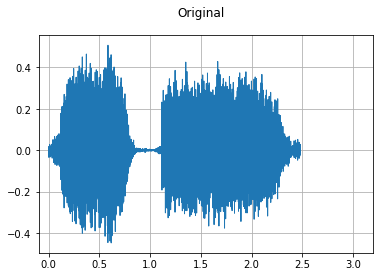

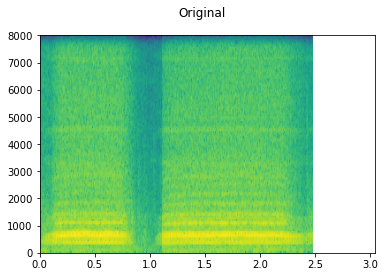

In [8]:
plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
play_audio(waveform1, sample_rate1)

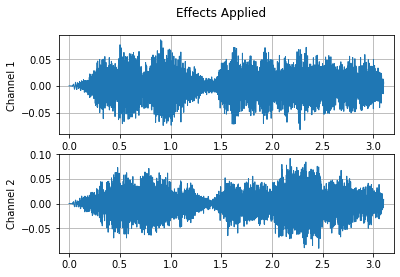

/home/wy/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


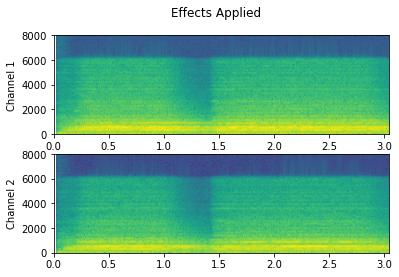

In [9]:
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
play_audio(waveform2, sample_rate2)

AudioMetaData(sample_rate=16000, num_frames=32000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


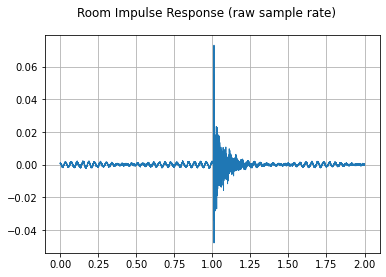

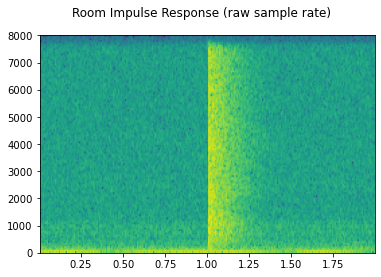

In [13]:
print(torchaudio.info(SAMPLE_RIR_PATH))
raw_rir_waveform, raw_rir_sample_rate = torchaudio.load(SAMPLE_RIR_URL)
plot_waveform(raw_rir_waveform, raw_rir_sample_rate, title="Room Impulse Response (raw sample rate)", ylim=None)
plot_specgram(raw_rir_waveform, raw_rir_sample_rate, title="Room Impulse Response (raw sample rate)")
play_audio(raw_rir_waveform, raw_rir_sample_rate)

通过原始音频和环境音频的卷积操作 就可以将原始音频中加入环境音频 得到增强的效果

torch.Size([1, 16000])


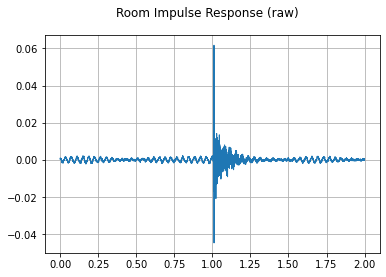

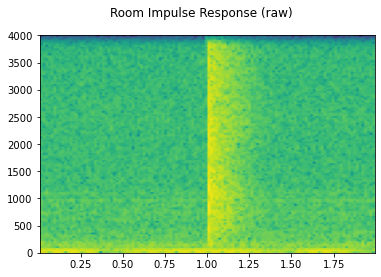

In [12]:
sample_rate = 8000

rir_raw, _ = get_rir_sample(resample=sample_rate)
print(rir_raw.shape)
# 以一半的采样率去做 那么视频时间不变 视频帧的个数就要减少一半 代表这个音频的向量就要降维一半

plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
play_audio(rir_raw, sample_rate)


In [14]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir.shape
# 取出rir_raw的第一秒开始往后0.3秒的部分

torch.Size([1, 2320])

Shape: (1, 2320)
Dtype: torch.float32
 - Max:      0.395
 - Min:     -0.286
 - Mean:    -0.000
 - Std Dev:  0.021

tensor([[-0.0052, -0.0076, -0.0071,  ...,  0.0184,  0.0173,  0.0070]])



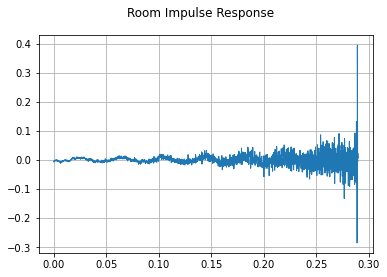

In [17]:
rir = rir / torch.linalg.norm(rir, dim = 1)
# rir除以它的均值 归一化
rir = torch.flip(rir, [1])
# 反转第一维

print_stats(rir)
plot_waveform(rir, sample_rate, title="Room Impulse Response", ylim=None)

In [25]:
play_audio(rir,sample_rate)
# 0.3s 归一化 反转后的情况

In [20]:
speech, _ = get_speech_sample(resample=sample_rate)
speech

tensor([[0.0068, 0.0196, 0.0187,  ..., 0.0016, 0.0022, 0.0023]])

In [21]:
speech_ = torch.nn.functional.pad(speech, (rir.shape[1] - 1, 0))
# 对speech进行pad 第二个参数如果只有两个值 那么就只对最后一维进行pad 第一个参数在左侧 第二个参数在右侧
print_stats(speech_)
augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]
augmented.shape
# conv1d用rir做卷积核 对speech_做卷积 由于stride是1 那么维度就是shape_speech_[1]-shape_rir[1]+1

Shape: (1, 29519)
Dtype: torch.float32
 - Max:      0.656
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.116

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0016, 0.0022, 0.0023]])



torch.Size([1, 27200])

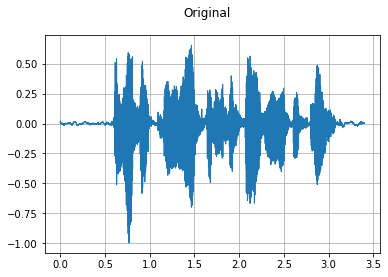

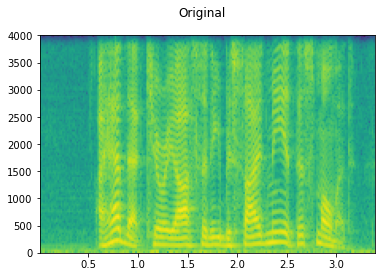

In [22]:
plot_waveform(speech, sample_rate, title="Original", ylim=None)
plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)
# 原始的情况

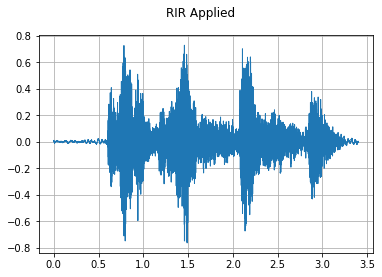

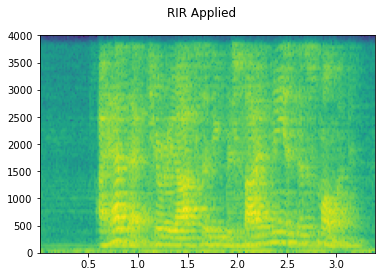

In [23]:
plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)
plot_specgram(augmented, sample_rate, title="RIR Applied")
play_audio(augmented, sample_rate)
# 用rir做卷积后的情况

向原始音频背景中加入噪音

In [28]:
sample_rate = 8000
speech, _ = get_speech_sample(resample=sample_rate)
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, : speech.shape[1]]
print_stats(speech, sample_rate)
print_stats(noise, sample_rate)

Sample Rate: 8000
Shape: (1, 27200)
Dtype: torch.float32
 - Max:      0.656
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.121

tensor([[0.0068, 0.0196, 0.0187,  ..., 0.0016, 0.0022, 0.0023]])

Sample Rate: 8000
Shape: (1, 27200)
Dtype: torch.float32
 - Max:      0.019
 - Min:     -0.018
 - Mean:    -0.000
 - Std Dev:  0.004

tensor([[ 1.7011e-04,  1.7426e-03,  4.0969e-03,  ..., -9.1195e-06,
          7.7236e-04,  2.8006e-03]])



In [29]:
speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)
# p=2是做二范数平均 根号下 每个值的平方和

In [30]:
snr_dbs = [20, 10, 3]
noisy_speeches = []
for snr_db in snr_dbs:
    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    noisy_speeches.append((scale * speech + noise) / 2)
# 使用不同的snr值 做noise

3

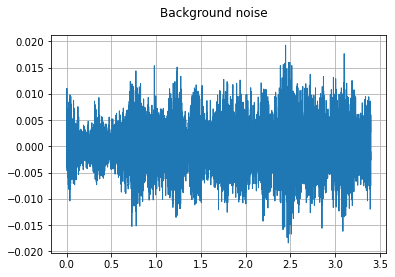

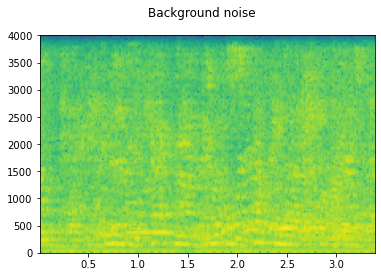

In [31]:
# 原始noise
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
play_audio(noise, sample_rate)

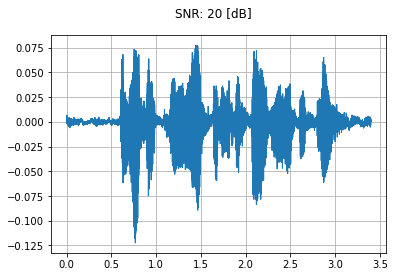

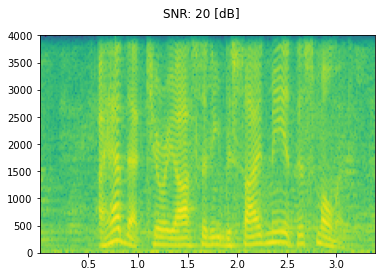

In [32]:
# 20分贝的noise
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
play_audio(noisy_speech, sample_rate)

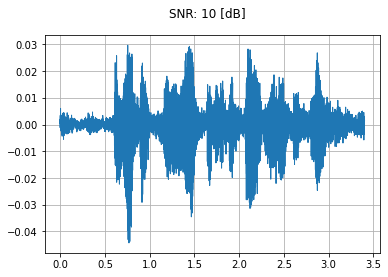

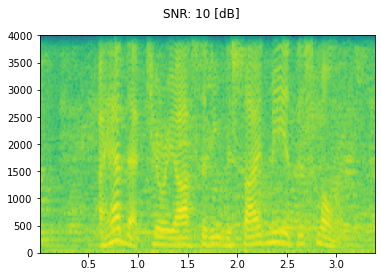

In [33]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
play_audio(noisy_speech, sample_rate)

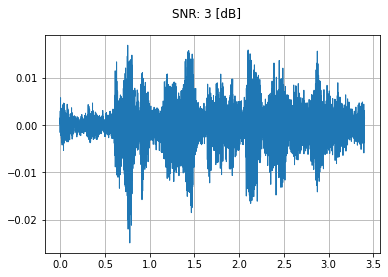

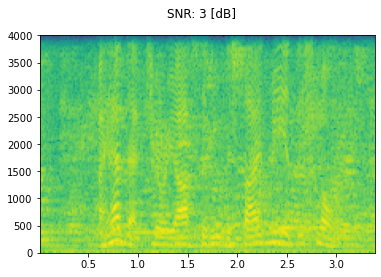

In [34]:
snr_db, noisy_speech = snr_dbs[2], noisy_speeches[2]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
play_audio(noisy_speech, sample_rate)

对tensor object解码为不同的音频

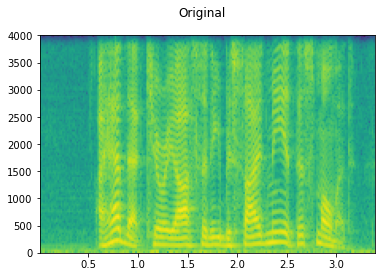

In [35]:
waveform, sample_rate = get_speech_sample(resample=8000)

plot_specgram(waveform, sample_rate, title="Original")

# 初始的wav格式音频

In [36]:
configs = [
    ({"format": "wav", "encoding": "ULAW", "bits_per_sample": 8}, "8 bit mu-law"),
    ({"format": "gsm"}, "GSM-FR"),
    ({"format": "mp3", "compression": -9}, "MP3"),
    ({"format": "vorbis", "compression": -1}, "Vorbis"),
]
# 字典对应了apply_codec()的不同参数
# 如format文件格式 encoding的形式 bits_per_sample采样的比特数 compression压缩

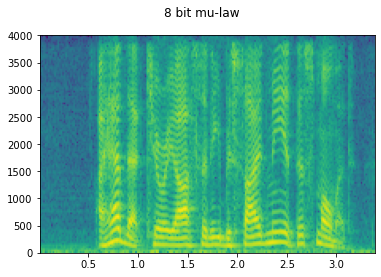

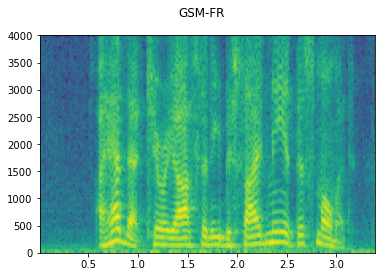

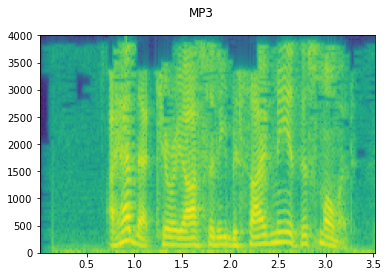

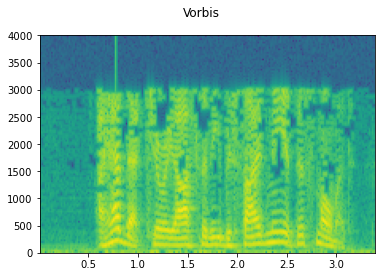

In [37]:
waveforms = []
for param, title in configs:
    augmented = F.apply_codec(waveform, sample_rate, **param)
    plot_specgram(augmented, sample_rate, title=title)
    waveforms.append(augmented)

In [38]:
play_audio(waveform, sample_rate)

In [40]:
play_audio(waveforms[0], sample_rate)

音频增强技术综合

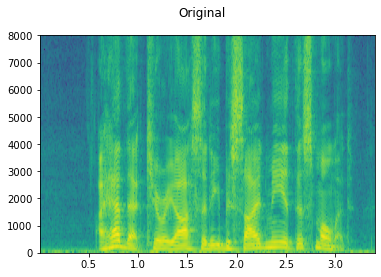

In [41]:
sample_rate = 16000
original_speech, _ = get_speech_sample(resample=sample_rate)

plot_specgram(original_speech, sample_rate, title="Original")

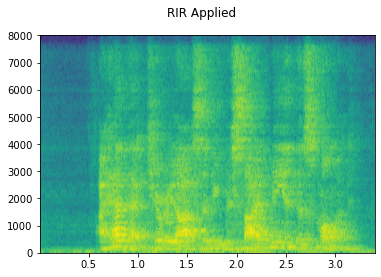

In [43]:
# 加入rir 房间内的音频增强
rir, _ = get_rir_sample(resample=sample_rate, processed=True)
# processed True会切0.3s + 归一化 + 反向
speech_ = torch.nn.functional.pad(original_speech, (rir.shape[1] - 1, 0))
rir_applied = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]
plot_specgram(rir_applied, sample_rate, title="RIR Applied")

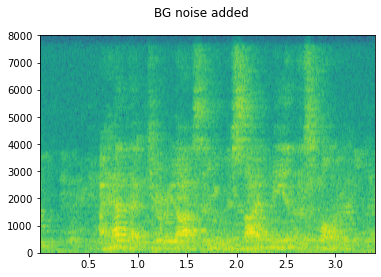

In [44]:
# 加入背景噪音 8dB的噪音
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, : rir_applied.shape[1]]

snr_db = 8
scale = math.exp(snr_db / 10) * noise.norm(p=2) / rir_applied.norm(p=2)
bg_added = (scale * rir_applied + noise) / 2

plot_specgram(bg_added, sample_rate, title="BG noise added")

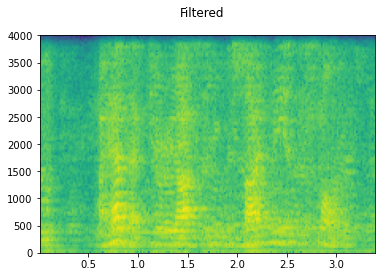

In [45]:
# 加入低通滤波 改变采样率
filtered, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    bg_added,
    sample_rate,
    effects=[
        ["lowpass", "4000"],
        [
            "compand",
            "0.02,0.05",
            "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8",
            "-8",
            "-7",
            "0.05",
        ],
        ["rate", "8000"],
    ],
)

plot_specgram(filtered, sample_rate2, title="Filtered")

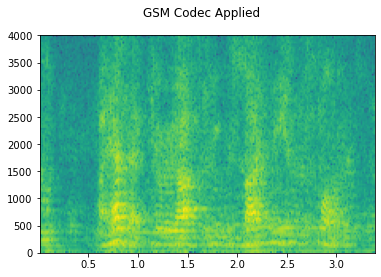

In [46]:
# 改变为gsm形式编码
codec_applied = F.apply_codec(filtered, sample_rate2, format="gsm")

plot_specgram(codec_applied, sample_rate2, title="GSM Codec Applied")

In [47]:
play_audio(original_speech, sample_rate)

In [48]:
play_audio(rir_applied, sample_rate)

In [49]:
play_audio(bg_added, sample_rate)

In [50]:
play_audio(filtered, sample_rate2)

In [51]:
play_audio(codec_applied, sample_rate2)